<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!export CUDA_VISIBLE_DEVICES=5


In [2]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# # This link may break due to google changing how files are linked. You can manually download from https://drive.google.com/drive/folders/1BOLGo3CFDa_qJMLRgtTZ6zrAWezk9oJu?usp=sharing 
# !curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
# !pip install ./deepul
from deepul.hw2_helper import *

In [3]:
import torch
import os

# Set the specific GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.use_cache = cache

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cached_k = None
        self.cached_v = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None, use_cache=False, past_key_values=None):
        batch_size, seq_len, d_model = x.shape
        if past_key_values is not None:
            self.cached_k, self.cached_v = past_key_values
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Use KV cache if enabled
        if use_cache and self.cached_k is not None and self.cached_v is not None:
            # Concatenate current k, v with cached k, v
            k = torch.cat([self.cached_k, k], dim=2)
            v = torch.cat([self.cached_v, v], dim=2)


            self.cached_k = k
            self.cached_v = v
        
        # Create causal mask if needed
        if mask is None:
            # If using cache, adjust mask to account for the full sequence length
            full_seq_len = k.size(2)
            # For cached version, we need to adjust the mask to allow attention to all past tokens
            if use_cache and self.cached_k is not None:
                # Create a mask where current tokens can attend to all previous tokens
                # Current sequence position is at seq_len
                seq_position = seq_len
                # Create a mask that allows each token to see itself and all previous tokens
                mask = torch.ones(seq_len, full_seq_len).to(x.device)
                # Make it causal by setting future positions to 0
                mask[:, seq_position:] = 0
            else:
                # Standard causal mask for the full sequence
                mask = torch.tril(torch.ones(full_seq_len, full_seq_len)).to(x.device)
            
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        past_key_values = (k, v)
        if use_cache:
            return self.dropout(self.out(output)) , past_key_values
        else:
            return self.dropout(self.out(output))
    
    def clear_cache(self):
        self.cached_k = None
        self.cached_v = None
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, use_cache=False):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout, cache=use_cache)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, use_cache=False, past_key_values=None):

        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        if use_cache and past_key_values is not None:
            x, past_key_values = self.masked_mha(x, use_cache=use_cache, past_key_values=past_key_values)
        else:
            x = self.masked_mha(x)
            
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        if use_cache:
            return x , past_key_values
        else:
            return x
    
    def clear_cache(self):
        self.masked_mha.clear_cache()

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1, use_cache=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cache = use_cache
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout, use_cache=use_cache) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x, past_key_values=None, use_cache=False):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        past_key_values = None
        for layer in self.decoder_layers:
            if use_cache:
                x, past_key_values = layer(x, use_cache=use_cache, past_key_values=past_key_values)
            else:
                x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        if use_cache:
            return logits, past_key_values
        else:
            return logits
    
    def clear_cache(self):
        for layer in self.decoder_layers:
            layer.clear_cache()

In [7]:
class residual(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1, 1, 0)
        )
        
    def forward(self, x):
        return x + self.residual_block(x)
    
class VQVAE(nn.Module):
    def __init__(self, dim,K,D ):
        super().__init__()
        assert dim == D, f"Encoder output dim ({dim}) must match codebook dim ({D})"
        self.encoder_residual_1= residual(dim)
        self.encoder_residual_2= residual(dim)
        
        self.decoder_residual_1= residual(dim)
        self.decoder_residual_2= residual(dim)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, dim, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=4, stride=2, padding=1),  # 8*8
            self.encoder_residual_1,
            self.encoder_residual_2,
        )
        
        self.decoder = nn.Sequential(
            self.decoder_residual_1,
            self.decoder_residual_2,
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.ConvTranspose2d(dim,dim,4,2,1), # 16*16
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.ConvTranspose2d(dim,3,4,2,1), # 32*32
        )
        
        self.codebook = nn.Embedding(K,D)
        nn.init.uniform_(self.codebook.weight, -1/K, 1/K)
    def encode(self,x):
        z_e = self.encoder(x)
        batch_size, channels, height, width = z_e.shape
        z_e_flat = z_e.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        z_e_flat = z_e_flat.view(-1, channels)  # [B*H*W, C]
        
        
        distances = torch.sum((z_e_flat.unsqueeze(1) - self.codebook.weight.unsqueeze(0))**2, dim=-1) 
        # z_e_flat -> [B*H*W, C] -> [B*H*W,1,  C]
        # self.codebook.weight.unsqueeze(0) -> [K, D] -> [1, K, D]
        # distances -> [B*H*W, K]
        

        k = torch.argmin(distances, dim=-1)  # [B*H*W]
        # k [B*H*W] -> [B*H*W, 1]
        z_q_flat = self.codebook(k)  # [B*H*W, D]
        z_q = z_q_flat.view(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()  # Back to [B, C, H, W]
        
        z_q = z_e + (z_q - z_e).detach() # Straight-through estimator
        return z_e, z_q
        
    def decode(self, z_q):
        x_recon = self.decoder(z_q)
        return x_recon
    
    def forward(self, x):
        z_e, z_q = self.encode(x)
        
        x_recon = self.decode(z_q)
        
        return z_e, z_q , x_recon
    # Add this method to the VQVAE class to extract discrete tokens
    def get_tokens(self, x):
        """Extract discrete tokens from input images"""
        z_e = self.encoder(x)
        batch_size, channels, height, width = z_e.shape
        z_e_flat = z_e.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        z_e_flat = z_e_flat.view(-1, channels)  # [B*H*W, C]
        
        distances = torch.sum((z_e_flat.unsqueeze(1) - self.codebook.weight.unsqueeze(0))**2, dim=-1)
        tokens = torch.argmin(distances, dim=-1)  # [B*H*W]
        
        return tokens.view(batch_size, height, width)  # [B, H, W]

    def decode_tokens(self, tokens):
        """Decode discrete tokens back to images"""
        batch_size, height, width = tokens.shape
        z_q_flat = self.codebook(tokens.view(-1))  # [B*H*W, D]
        z_q = z_q_flat.view(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()
        return self.decode(z_q)

def compute_loss(x, recon_x, z_e, z_q):
    recon_loss = F.mse_loss(recon_x, x)
    vq_loss = F.mse_loss(z_q.detach(), z_e)  # Move codebook towards encoder
    commit_loss = F.mse_loss(z_e, z_q.detach())  # Commit encoder to codebook
    
    return recon_loss + vq_loss + 0.25 * commit_loss
    
def evaluate_VQVAE(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    total_loss = 0 
    n_batches = 0
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            z_e , z_q, recon_x  = model(x)
            
            loss = compute_loss(x,recon_x, z_e, z_q)
            
            total_loss += loss.item()
            
            n_batches += 1 
            
    return total_loss/ n_batches


In [8]:
def prepare_transformer_data(vqvae_model, data_loader, device):
    """Extract tokens from VQ-VAE for transformer training"""
    vqvae_model.eval()
    all_tokens = []
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            tokens = vqvae_model.get_tokens(x)  # [B, H, W]
            
            # Flatten and add start token
            batch_size, H, W = tokens.shape
            tokens_flat = tokens.view(batch_size, -1)  # [B, H*W]
            
            # Add start token (0) at the beginning
            tokens_with_start = torch.cat([
                torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                tokens_flat + 1  # Shift tokens by 1 to make room for start token
            ], dim=1)  # [B, H*W + 1]
            
            all_tokens.append(tokens_with_start.cpu())
    
    return torch.cat(all_tokens, dim=0)

def train_transformer_prior(vqvae_model, train_loader, test_loader, device, vocab_size=129, n_epochs=10):
    """Train transformer prior on VQ-VAE tokens"""
    
    # Prepare training data
    print("Extracting tokens from VQ-VAE...")
    train_tokens = prepare_transformer_data(vqvae_model, train_loader, device)
    test_tokens = prepare_transformer_data(vqvae_model, test_loader, device)
    
    sequence_length = train_tokens.shape[1]  # H*W + 1
    
    # Create transformer model
    transformer = iGPT(
        vocab_size=vocab_size,  # 128 codebook + 1 start token
        context_length=sequence_length,
        d_model=512,
        n_heads=8,
        n_layers=6,
        dropout=0.1,
        use_cache=True
    ).to(device)
    
    optimizer = optim.Adam(transformer.parameters(), lr=3e-4)
    
    # Create data loaders for transformer training
    train_dataset = TensorDataset(train_tokens)
    test_dataset = TensorDataset(test_tokens)
    train_loader_transformer = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader_transformer = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    test_loss = evaluate_transformer(transformer, test_loader_transformer, device)
    test_losses.append(test_loss)
    print(f"Initial Transformer Test Loss: {test_loss:.4f}")
    
    transformer.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        
        for batch in train_loader_transformer:
            tokens = batch[0].to(device)
            
            # Prepare input and target
            input_tokens = tokens[:, :-1]  # All but last token
            target_tokens = tokens[:, 1:]   # All but first token
            
            optimizer.zero_grad()
            logits = transformer(input_tokens)
            
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), target_tokens.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_losses.append(loss.item())
            train_losses.append(loss.item())
        
        # Evaluate on test set
        test_loss = evaluate_transformer(transformer, test_loader_transformer, device)
        test_losses.append(test_loss)
        
        avg_train_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return transformer, train_losses, test_losses

def evaluate_transformer(model, data_loader, device):
    """Evaluate transformer model"""
    model.eval()
    total_loss = 0
    n_batches = 0
    vocab_size = model.vocab_size
    
    with torch.no_grad():
        for batch in data_loader:
            tokens = batch[0].to(device)
            
            input_tokens = tokens[:, :-1]
            target_tokens = tokens[:, 1:]
            
            logits = model(input_tokens)
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), target_tokens.reshape(-1))
            
            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches

def sample_from_prior(transformer, vqvae_model, device, num_samples=100, H=8, W=8):
    """Sample from transformer prior and decode with VQ-VAE"""
    sequence_length = H * W + 1  # +1 for start token
    vocab_size = transformer.vocab_size
    
    samples = []
    transformer.eval()
    
    with torch.no_grad():
        for i in range(num_samples):
            # Start with just the start token (0)
            sample = torch.zeros(1, sequence_length, dtype=torch.long, device=device)
            
            # Generate sequence autoregressively
            for pos in range(1, sequence_length):
                logits = transformer(sample[:, :pos])
                logits = logits[:, -1, :]  # Get prediction for next token
                
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1).squeeze(-1)
                sample[:, pos] = next_token
            
            # Convert tokens back to image (remove start token and shift back)
            tokens = sample[:, 1:] - 1  # Remove start token and shift back
            tokens = tokens.clamp(0, 127)  # Ensure valid token range
            tokens = tokens.view(1, H, W)
            
            # Decode with VQ-VAE
            reconstructed = vqvae_model.decode_tokens(tokens)
            
            # Convert back to [0, 255] range and proper format
            reconstructed = (reconstructed * 127.5 + 127.5).clamp(0, 255)
            reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            
            samples.append(reconstructed)
    
    return np.array(samples)

def generate_reconstructions(vqvae_model, test_loader, device, num_pairs=50):
    """Generate real image / reconstruction pairs"""
    vqvae_model.eval()
    pairs = []
    
    with torch.no_grad():
        for batch in test_loader:
            if len(pairs) >= num_pairs:
                break
                
            x = batch[0].to(device)
            z_e, z_q, recon_x = vqvae_model(x)
            
            # Convert back to [0, 255] range
            real_images = (x * 127.5 + 127.5).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
            recon_images = (recon_x * 127.5 + 127.5).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
            
            for i in range(min(x.shape[0], num_pairs - len(pairs))):
                pairs.append(real_images[i])
                pairs.append(recon_images[i])
    
    return np.array(pairs[:num_pairs * 2])  # 50 pairs = 100 images

# Update the q3 function
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 128
    learning_rate = 1e-3
    n_epochs_vqvae = 30
    
    # Prepare data
    train_data = train_data.transpose(0, 3, 1, 2) / 127.5 - 1
    test_data = test_data.transpose(0, 3, 1, 2) / 127.5 - 1
    
    train_tensor = torch.FloatTensor(train_data)
    test_tensor = torch.FloatTensor(test_data)
    
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train VQ-VAE
    print("Training VQ-VAE...")
    model = VQVAE(dim=256, K=128, D=256).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    vqvae_train_losses = []
    vqvae_test_losses = []
    
    # Initial evaluation
    test_loss = evaluate_VQVAE(model, test_loader)
    print(f"Initial VQ-VAE Test Loss: {test_loss:.4f}")
    vqvae_test_losses.append(test_loss)
    
    # Training loop
    model.train()
    for epoch in range(n_epochs_vqvae):
        epoch_train_losses = []
        
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device)
            optimizer.zero_grad()
            z_e, z_q, recon_x = model(x)
            
            loss = compute_loss(x, recon_x, z_e, z_q)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
            vqvae_train_losses.append(loss.item())
        
        # Evaluate after each epoch
        test_loss = evaluate_VQVAE(model, test_loader)
        vqvae_test_losses.append(test_loss)
        
        if (epoch + 1) % 1 == 0:
            avg_train = np.mean(epoch_train_losses)
            print(f"VQ-VAE Epoch {epoch+1}/{n_epochs_vqvae} - Train Loss: {avg_train:.4f}, Test Loss: {test_loss:.4f}")
    
    # Train Transformer Prior
    print("\nTraining Transformer Prior...")
    transformer, prior_train_losses, prior_test_losses = train_transformer_prior(
        model, train_loader, test_loader, device
    )
    
    # Generate samples
    print("\nGenerating samples...")
    samples = sample_from_prior(transformer, model, device, num_samples=100)
    
    # Generate reconstructions
    print("Generating reconstructions...")
    reconstructions = generate_reconstructions(model, test_loader, device, num_pairs=50)
    
    return (vqvae_train_losses, vqvae_test_losses, 
            prior_train_losses, prior_test_losses, 
            samples, reconstructions)

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

Training VQ-VAE...
Initial VQ-VAE Test Loss: 0.2403
VQ-VAE Epoch 1/10 - Train Loss: 43.3350, Test Loss: 54.6619
VQ-VAE Epoch 2/10 - Train Loss: 31.2758, Test Loss: 44.3140
VQ-VAE Epoch 3/10 - Train Loss: 32.4184, Test Loss: 50.2800
VQ-VAE Epoch 4/10 - Train Loss: 34.6917, Test Loss: 39.6002
VQ-VAE Epoch 5/10 - Train Loss: 27.5441, Test Loss: 38.1024
VQ-VAE Epoch 6/10 - Train Loss: 23.3247, Test Loss: 20.7958
VQ-VAE Epoch 7/10 - Train Loss: 21.5851, Test Loss: 20.2706
VQ-VAE Epoch 8/10 - Train Loss: 20.4442, Test Loss: 28.2281
VQ-VAE Epoch 9/10 - Train Loss: 18.6446, Test Loss: 29.3255
VQ-VAE Epoch 10/10 - Train Loss: 18.0613, Test Loss: 27.7885

Training Transformer Prior...
Extracting tokens from VQ-VAE...
Initial Transformer Test Loss: 5.0315
Epoch 1/15 - Train Loss: 2.1541, Test Loss: 1.9287
Epoch 2/15 - Train Loss: 1.9465, Test Loss: 1.8626
Epoch 3/15 - Train Loss: 1.8807, Test Loss: 1.8423
Epoch 4/15 - Train Loss: 1.8296, Test Loss: 1.8318
Epoch 5/15 - Train Loss: 1.7799, Test Los

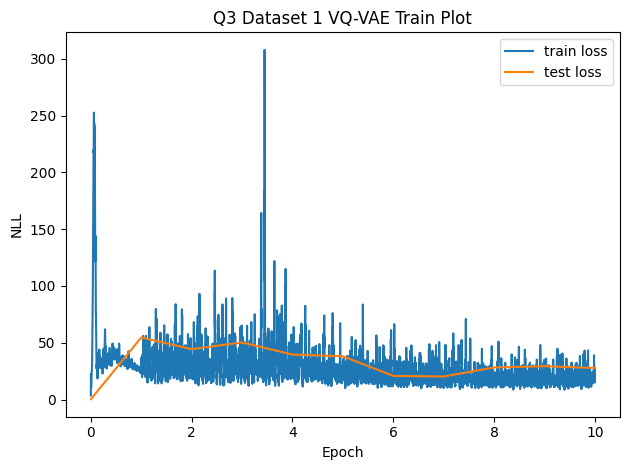

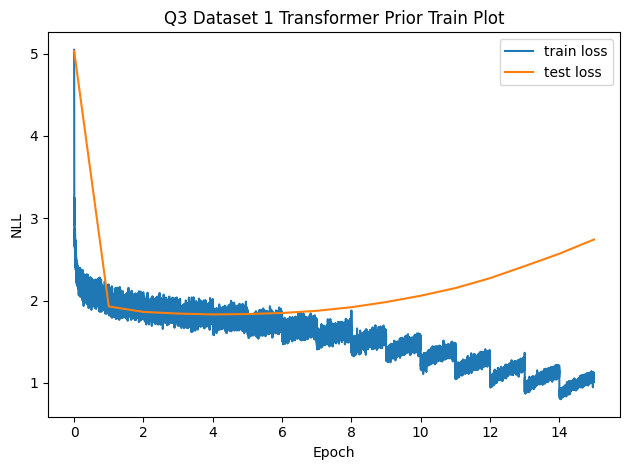

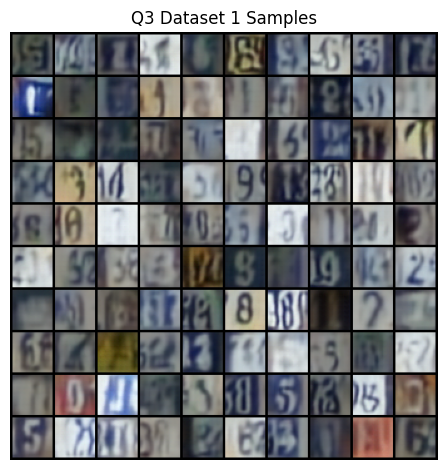

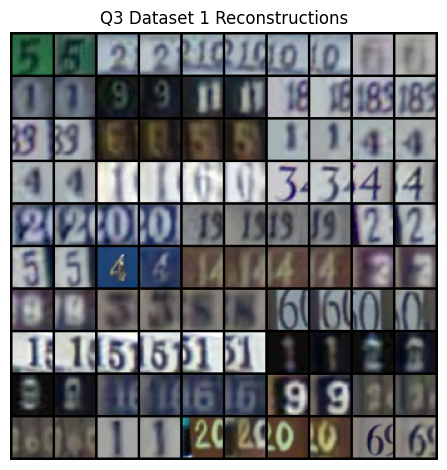

In [9]:
q3_save_results(1, q3)

In [10]:
q3_save_results(2, q3)

Training VQ-VAE...
Initial VQ-VAE Test Loss: 0.2765
VQ-VAE Epoch 1/10 - Train Loss: 67.0841, Test Loss: 78.4595
VQ-VAE Epoch 2/10 - Train Loss: 122.8201, Test Loss: 120.5956
VQ-VAE Epoch 3/10 - Train Loss: 127.9598, Test Loss: 88.9482
VQ-VAE Epoch 4/10 - Train Loss: 105.5193, Test Loss: 99.7832
VQ-VAE Epoch 5/10 - Train Loss: 99.8020, Test Loss: 82.3810
VQ-VAE Epoch 6/10 - Train Loss: 87.6053, Test Loss: 100.0486


KeyboardInterrupt: 

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)